# OR Tools for Robot & Drone VRP

##### **目標**

比較 **VRP**、**Drone VR**、**Robot VRP**、**Drone & Robot VRP**，四種組合在不同參數下的表現

- **表現指標**: 總路徑時間, 總路徑長度, 時間複雜度, 空間複雜度 

##### **參數**
- 不同地圖大小 (5x5, 10x10, 15x15, 20x20, 25x25)
- 不同客戶數量 (210, 180, 150, 130, 110): 從 30 次的重複模擬實驗結果取平均, 趨近於 8 小時的 Nodes 數量
- 1 台車
- 蒙地卡羅模擬次數 10 次以上

##### **實驗假設**

- 每個客戶點的貨物數量、尺寸皆相同
- 每個客戶點的服務時間皆為 2 分鐘
- 實驗載具共有 Truck、Drone 與 Robot 三種載具
- 一台 Truck 配置 1 台 Drone 與 Robot，且 Drone 與 Robot 可以同時在路上跑
- Drone 與 Robot 可以由 Truck 於任意客戶點中派出與回收，派出與回收各需要花費 1 分鐘
- Truck 可以多次派出 Drone 與 Robot
- 若 Truck 抵達回收點時 Drone 與 Robot 尚未返回，需記錄等待時間
- 司機可以有等待時間，但不能提前 10 分鍾以上到達
- Truck 載具的速度為 60 km/hr，使用曼哈頓距離計算，載貨量為 **服務點 ÷ 車輛數** (考量平均工作量)
- Drone 載具的速度為 80 km/hr，使用歐式距離計算，每次只能載 1 個貨物, 電池續航力為 60 分鐘
- Robot 載具的速度為 60 km/hr，使用曼哈頓距離計算，每次只能載 4 個貨物, 電池續航力為 120 分鐘

##### **Drone 挑選方法說明**

- 以 OR-Tools 初始解分組, 找出每組中最適合派給 Drone 的點
- 篩選出最近點距離最遠的 n 個點作為 Drone 效益最高的點, n 設定為 25 百分位數
- 設定其原路徑為 Drone 的可能發收站, 並排除掉 Node 為其他 Drone 發收站的點

##### **Robot 挑選方法**

- 從 Initial Solution 中抓出最短的路徑組合 (10 個造訪點一組, 如數量 <= 10 則不考慮出車)
- 路徑組合的造訪時間不可超過 Robot 電池續航力
- 根據距離排序, 排除掉 Node 重複的組合
- 篩選出前 25 百分位數近的組合

In [16]:
import random as rd
import numpy as np
import pandas as pd
import math
import copy as copy
# OR-Tools
from ortools.constraint_solver import routing_enums_pb2 
from ortools.constraint_solver import pywrapcp 
# Record time & space complexity
import time 
import tracemalloc
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## Parameters: 實驗參數設定

In [17]:
# [實驗控制變數] 
# 地圖大小(km) | 服務點數量 | 車輛數量
# MAX_X, MAX_Y = 20, 20
# NUM_NODES = 30
# NUM_VEHICLES = 1

# 站點服務時間
SERVICE_TIME = 2

# [Truck]
# 時速 60km | 每台車有最大移動距離(固定) | 貨物重量相同 | 本實驗不考慮車輛成本, 故每台車可載貨物數量 = (站點/車輛數)
VEHICLE_SPEED = 60
# VEHICLE_CAPACITIES = int(NUM_NODES / NUM_VEHICLES)

# [Drone]
# 時速 80km | 續航力 60 min | 採用歐幾里德距離 | 負責離群值 | 派出與收回載具各需要 1 分鐘 (總共2)
DRONE_CAPACITIES = 1
DRONE_SPEED = 80
DRONE_BATTERY_LIFE = 60

# [Robot]
# 時速 30km | 續航力 120 min | 負責高密度點 | 派出與收回載具各需要 1 分鐘 (總共2)
ROBOT_CAPACITIES = 10
ROBOT_SPEED = 60
ROBOT_BATTERY_LIFE = 120

## Model: 資料層設定

In [19]:
# 模擬實驗需求, 函式需帶入控制變數
# **controls = dict(map_size=(20, 20), num_nodes=20, num_vehicles=1, trials=10)
def create_data_model(**controls):

    NUM_NODES = controls["num_nodes"]
    MAX_X, MAX_Y = controls["map_size"][0], controls["map_size"][1]
    NUM_VEHICLES = controls["num_vehicles"]
    VEHICLE_CAPACITIES = controls["num_nodes"] // controls["num_vehicles"] # 如果非整數需分配給其他車輛
    
    data = {}
    data["num_locations"] = [(round(np.random.uniform(0, MAX_X),2), round(np.random.uniform(0, MAX_Y),2)) for i in range(NUM_NODES)]
    data["num_locations"][0] = (round((MAX_X / 2), 2), round((MAX_Y / 2), 2)) 
    data["distance_matrix"] = compute_manhattan_distance_matrix(data["num_locations"]) # 距離矩陣必須為整數, 否則無法在 OR-Tools 中求解
    data["e_distance_matrix"] = compute_euclidean_distance_matrix(data["num_locations"]) # 歐幾里德距離, 取小數第二位(drone 使用)
    data["time_matrix"] = compute_time_matrix(data["distance_matrix"]) # 最小單位分鐘
    data["num_nodes"] = NUM_NODES
    data["num_vehicles"] = NUM_VEHICLES
    data["depot"] = 0 # Depot 的索引值
    data["time_windows"] = []
    data["initial_routes"] = [] # 如果有初始解可以套用
    data["demands"] = [1 for i in range(NUM_NODES)]
    data["demands"][0] = 0
    data["vehicle_capacities"] = [VEHICLE_CAPACITIES for i in range(NUM_VEHICLES)]
    if NUM_NODES % VEHICLE_CAPACITIES > 0:
        for i in range(NUM_NODES % VEHICLE_CAPACITIES):
            data["vehicle_capacities"][i] += 1
    # 三個載具負責的 node 索引值
    data["vehicle"] = []
    data["drone"] = []
    data["robot"] = []    
    return data

# 曼哈頓距離矩陣, truck & robot 用 (單位使用 km, 小於 1km 的距離會無法解題)
def compute_manhattan_distance_matrix(nodes):
    distance_matrix = []
    for node_i in nodes:
        distances = []
        for node_j in nodes:
            if node_i == node_j:
                distances.append(0)
            else:
                manhattan_distance = np.sum(np.abs(np.array(node_i) - np.array(node_j)))
                distances.append(int(manhattan_distance))
        distance_matrix.append(distances)
    return distance_matrix

# 歐式距離矩陣, drone 使用 (單位 km)
def compute_euclidean_distance_matrix(nodes):
    distance_matrix = []
    for node_i in nodes:
        distances = []
        for node_j in nodes:
            if node_i == node_j:
                distances.append(0)
            else:
                euclidean_distance = np.sqrt((node_i[0] - node_j[0])**2 + (node_i[1] - node_j[1])**2)
                distances.append(int(euclidean_distance))
        distance_matrix.append(distances)
    return distance_matrix

# 距離矩陣轉換為時間矩陣 (兩點花費分鐘 = 公里 / 時速 * 60)
def compute_time_matrix(distance_matrix):
    time_matrix = []
    for i in distance_matrix:
        time_matrix.append(list(map(lambda x: round(x / VEHICLE_SPEED * 60, 2), i)))
    return time_matrix

## Controller: 控制層設定

In [20]:
# 取得目標值(時間和/分鐘): 提供路徑, 速度, 參考距離矩陣, 會考量每個點的服務時間
def get_objective_value(data, route, speed=VEHICLE_SPEED, matrix='distance_matrix'):
    objective_value = 0
    for i in range(len(route) - 1):
        objective_value += (data[matrix][route[i]][route[i + 1]]) + SERVICE_TIME # 該點服務時間
    objective_value = objective_value / speed * 60
    return round(objective_value, 2)

# 計算路徑總距離
def get_total_distance(data, route):
    total_dist = 0
    for i in range(len(route) - 1):
        total_dist += data['distance_matrix'][route[i]][route[i + 1]]
    return round(total_dist, 2)

# 計算每台車的總等待時間
def get_waiting_time(data, routes, sidekick_routes, name):
    assert name == 'drone' or name == 'robot'
    # print(f'Vehicle: \n{name}')
    total = 0
    waiting_time_list = [[] for i in range(len(sidekick_routes))]
    for i, group in enumerate(sidekick_routes):
        for j, r_s in enumerate(group): # 每筆路徑
            if name == 'drone':
                dur_s = get_objective_value(data, r_s, DRONE_SPEED, 'e_distance_matrix')
            elif name == 'robot':
                dur_s = get_objective_value(data, r_s, ROBOT_SPEED, 'distance_matrix')
            start, end = r_s[0], r_s[-1]
            r_v = routes[i][routes[i].index(start):routes[i].index(end)+1]
            dur_v = get_objective_value(data, r_v, VEHICLE_SPEED)      
            # print(f'Sidekick: {r_s}, Vehicle: {r_v}')
            # print(f'-T(s): {dur_s}, T(v): {dur_v}')
            if dur_s > dur_v: # 如果 sidekick 時間比較長, 記錄為等待時間
                # print('-Wait for:', (dur_s - dur_v))
                waiting_time_list[i].append(round(dur_s - dur_v, 2))  
                total += (dur_s - dur_v)
            else:
                waiting_time_list[i].append(0)
        if waiting_time_list[i] == []:
            waiting_time_list[i] = [0]
    return waiting_time_list

# 計算每台車輛的總服務時間: 目標值 + 等待時間 + 收放時間; VRP 問題不會有等待時間
def get_travelling_time(data, routes, drone_waiting=[], robot_waiting=[]):

    total_dist, total_time, total_waiting  = [], [], []

    for index, route in enumerate(routes):
        dist = round(get_total_distance(data, route), 2)
        dur_v = get_objective_value(data, route)
        waiting = 0

        if len(drone_waiting) > 0:
            dur_v += round(np.sum(drone_waiting[index]), 2)
            waiting += round(np.sum(drone_waiting[index]), 2)

        if len(robot_waiting) > 0:
            dur_v += round(np.sum(robot_waiting[index]), 2)
            waiting += round(np.sum(robot_waiting[index]), 2)

        total_dist.append(dist)
        total_time.append(dur_v)
        total_waiting.append(waiting)
        print(f'Vehicle {index}: {dist} km, {dur_v} min, including {waiting} mins waiting time.')

    print(f'Total distance of all routes: : {np.sum(total_dist)} km')
    print(f'Maximum travel time: {max(total_time)} min')
    return total_dist, total_time, total_waiting

# 計算派遣載具時間(1+1 = 2)
def get_dispatch_time(routes):
    dispatch_time = []
    for i, group in enumerate(routes):
        dispatch_time.append(len(group) * 2)
    return dispatch_time

# 重置 Node 的貨物需求
def reset_demands(data, **controls):

    NUM_VEHICLES = controls["num_vehicle"]
    VEHICLE_CAPACITIES = int(controls["num_nodes"] / controls["num_vehicle"])
    data["demands"] = [1 for i in range(data["num_nodes"])]
    data["demands"][0] = 0
    data["vehicle_capacities"] = [VEHICLE_CAPACITIES for i in range(NUM_VEHICLES)]
    return data

def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    print(f"Objective: {solution.ObjectiveValue()}")
    total_distance = 0
    total_load = 0

    for vehicle_id in range(data["num_vehicles"]):
        index = routing.Start(vehicle_id)
        plan_output = f"Route for vehicle {vehicle_id}:\n"
        route_distance = 0
        route_load = 0
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route_load += data["demands"][node_index]
            plan_output += f" {node_index} ({route_distance}) -> "
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id
            )
        plan_output += f" {manager.IndexToNode(index)} ({route_distance})\n"
        plan_output += f"Distance of the route: {route_distance} km\n"
        plan_output += f"Load of the route: {route_load}\n"
        print(plan_output)
        total_distance += route_distance
        total_load += route_load
    
    print(f"Total distance of all routes: {total_distance} km")
    print(f"Total load of all routes: {total_load}")

# Save routes to a list or array
def get_routes(solution, routing, manager):
    """Get vehicle routes from a solution and store them in an array."""
    # Get vehicle routes and store them in a two dimensional array whose
    # i,j entry is the jth location visited by vehicle i along its route.
    routes = []
    for route_nbr in range(routing.vehicles()):
        index = routing.Start(route_nbr)
        route = [manager.IndexToNode(index)]
        while not routing.IsEnd(index):
            index = solution.Value(routing.NextVar(index))
            route.append(manager.IndexToNode(index))
        routes.append(route)
    return routes

# OR Tools = manager + routing + search_parameter = solution
def solve_routing_problem(data):
    ''' 路徑管理員 RoutingIndexManager '''
    # data 中有新資料需於此處引用
    manager = pywrapcp.RoutingIndexManager(
        len(data["distance_matrix"]), data["num_vehicles"], data["depot"]
    )
    ''' 路徑資料 RoutingModel '''
    routing = pywrapcp.RoutingModel(manager)
    # 計算 node 貨物需求的工具
    def demand_callback(from_index):
        from_node = manager.IndexToNode(from_index)
        return data["demands"][from_node]

    demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_callback_index,
        0,  # null capacity slack
        data['vehicle_capacities'],  # vehicle maximum capacities
        True,  # start cumul to zero
        "Capacity",
    )

    # 計算 node 間距離單位的工具, 調整距離計算方法可從函式 return 中修改
    def distance_callback(from_index, to_index):
        from_node = manager.IndexToNode(from_index) # 取得開始到結束點的索引值
        to_node = manager.IndexToNode(to_index)
        return data["distance_matrix"][from_node][to_node] # 若題目為 VRPTW 需回傳 data["time_matrix"]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback) # 設定所有車輛距離(arc)間的評估單位
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)
    # routing.SetArcCostEvaluatorOfVehicle() # 打開後可定義其他車輛距離的評估單位

    # 設定車輛行駛中累積的變量, VRPTW 時需將 demension_name 調整為 "Time"
    routing.AddDimension(
        transit_callback_index,
        0,  # 車輛最大等待時間, VRPTW 用
        999999999,  # 車輛最大行駛距離
        True,  # 每輛車路線開始時，累計變數是否設為零 (VRPTW 時需調整為 False, 讓時間可累積)
        "Distance",
    )
    distance_dimension = routing.GetDimensionOrDie("Distance")
    # distance_dimension.SetGlobalSpanCostCoefficient(0) # 成本係數設定成 100 會無法跑少數量的車輛路線

    # 設計懲罰項: AddDisjuntion() 只能呼叫一次, 要將 node 排除在路徑中需要調整 Capacity
    penalty = 1000
    for node in range(1, len(data["distance_matrix"])):
        routing.AddDisjunction([manager.NodeToIndex(node)], penalty)

    # 平衡車輛 loading, 避免部分車輛跑有路線
    for vehicle_id in range(data['num_vehicles']):
        routing.SetVehicleUsedWhenEmpty(True, vehicle_id)

    routing.AddConstantDimension(
        1, # +1 for each visit (note start node is counted so unused vehicle is still 1)
        data["num_nodes"] // data["num_vehicles"] + 2, # max visit allowed,  hard limit
        True,  # start cumul to zero
        "Counter")
        
    counter_dimension = routing.GetDimensionOrDie("Counter")
    for vehicle_id in range(manager.GetNumberOfVehicles()):
        index = routing.End(vehicle_id)
        counter_dimension.SetCumulVarSoftLowerBound(index, 2, 100000) # penalty of 100000 for each empty vehicle since counter will be 1 aka (2 - 1) * 100_000  

    ''' 啟發式演算法參數 search_parameters '''
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC # 最快求解法, 預設為 PATH_CHEAPEST_ARC '''
    )
    search_parameters.local_search_metaheuristic = (
        routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH     # 開啟後會改用 guided local search 求解 local minimum (GREEDY_DESCENT, TABU_SEARCH, Simulated Annealing...)
    )
    # search_parameters.time_limit.seconds = 5 # 搜尋時間限制
    # search_parameters.log_search = True # 開啟後會顯示每次搜尋迭代(log)
    search_parameters.solution_limit = 100 # 解決方案限制
    
    routing.CloseModelWithParameters(search_parameters) # 提供初始解時關閉搜尋參數
    # initial_solution = routing.ReadAssignmentFromRoutes(data["initial_routes"], True) # 求解前如果想提供初始路徑解可打開

    solution = routing.SolveWithParameters(search_parameters) # 將準備好的 search_parameter 提供給 OR Tools 求解
    if solution: # 有找到解的話顯示答案
        routes = get_routes(solution, routing, manager)
        print(f'Routes: {routes}, Length: {len(routes[0])}')
        # print_solution(data, manager, routing, solution)
        return routes
    else:
        print('No solution!')
        return []

In [21]:
def select_drone_nodes(data, routes, excludes=[]):

    # 找出最近距離 Node 排序
    nearest_dists = []
    for i in data['e_distance_matrix']:
        sorted_i = sorted(i)
        nearest_dists.append(sorted_i[1])
    sorted_nearest_indexes = np.argsort(nearest_dists).tolist()[::-1]
    sorted_nearest_indexes = sorted_nearest_indexes[:int(data["num_nodes"])] 
    sorted_nearest_indexes.remove(0)

    # 將 Node 分配到初始解車輛路徑中
    drone_nodes = [[] for i in range(len(routes))]
    for i, route in enumerate(routes):
        for j in sorted_nearest_indexes:
            drone_nodes[i].append(j) if j in route else None
        drone_nodes[i] = drone_nodes[i][:int(len(route)/4)] # 根據中位數篩選出前 25% 最遠的點

    # 如果有先解出 Robot 點, 需將 Robot 的收發站排除掉
    if len(excludes) > 0:
        for i, group in enumerate(excludes):
            for j, nodes in enumerate(group):
                for n in nodes:
                    drone_nodes[i].remove(n) if n in drone_nodes[i] else None
         
    drone_routes = [[] for i in range(len(routes))]
    for i, group in enumerate(drone_nodes):
        exclusion = []
        # 取得 Drone 的合適路徑
        for n in group:
            # 原路徑鄰的點不能為其他 Drone 點
            if n not in exclusion:
                start, end = routes[i].index(n)-1, routes[i].index(n)+1
                exclusion.append(routes[i][start])
                exclusion.append(routes[i][end])
                route = [routes[i][start], n, routes[i][end]]
                drone_routes[i].append(route)
                
    # 排除會造成等待的 Drone 路線
    for i, group in enumerate(drone_routes):
        for r in group:
            dur_d = get_objective_value(data, r, DRONE_SPEED, 'e_distance_matrix')
            start, end = r[0], r[-1]
            r_v = routes[i][routes[i].index(start):routes[i].index(end)+1]
            dur_v = get_objective_value(data, r_v, VEHICLE_SPEED)      
            if dur_d + 2 >= dur_v: # Drone 較晚到達會產生等待 & 多花 2min 派遣 Drone 不如自己去跑
                # print('Remove:', r)
                drone_routes[i].remove(r)

    return drone_routes

In [8]:
def select_robot_nodes(data, routes):

    robot_routes = [[] for i in range(len(routes))]
    
    for index, route in enumerate(routes):
        # print('Choosing the nodes for Robot:', route)
        if len(route) <= ROBOT_CAPACITIES + 2:
            continue
        route_filter = []
        for j in range(len(route)):
            if j <= (len(route) - ROBOT_CAPACITIES - 2):
                robot_route = route[j:j + ROBOT_CAPACITIES + 2]            
                r_dur = get_objective_value(data, robot_route, ROBOT_SPEED)
                if r_dur <= ROBOT_BATTERY_LIFE: # 排除超過電池續航力(ROBOT_BATTERY_LIFE)的路徑組合
                    # print(f'Route {j}: {robot_route}, Duratoin: {r_dur}')
                    route_filter.append({ 'route': robot_route, 'duration': r_dur }) 
        # 根據最短時間(duration)排序, 並排除掉重複 Node 的路徑組合
        route_filter.sort(key=lambda x: x['duration'])
        if len(route_filter) >= ROBOT_CAPACITIES:
            route_filter = route_filter[:int(len(route_filter)/4)] # 保留 25% 路徑組合
        best_routes = [route_filter[0]['route']]
        # print(best_routes)
        for r_dict in route_filter:
            overlap = 0
            for best_r in best_routes:
                if len(set(best_r) & set(r_dict['route'])) > 0:
                    overlap += 1
                    break
            if overlap == 0:
                best_routes.append(r_dict['route'])
        robot_routes[index] = best_routes
    # 每台車只會派出 Robot 一次
    # robot_routes = [[robot_routes[i][0]] for i in range(len(routes))]
    print('Robot Routes:', robot_routes)
    return robot_routes

def adjust_robot_route(data, route, robot_group):
    print(f"Route: {route}, Robot Group: {robot_group}")
    a_route = route.copy()
    a_robot_group = robot_group.copy()

    for index, route_r in enumerate(robot_group):
        route_t = [route_r[0], route_r[-1]]
        dur_r = get_objective_value(data, route_r, ROBOT_SPEED)
        dur_t = get_objective_value(data, route_t)
        if dur_r + 2 > dur_t:
            # 1. forward stepwise search
            route_f = route[route.index(route_t[-1])+1:] if route_t[-1] != 0 else [0]
            # exclude other dispatch nodes
            for i in a_robot_group:
                if i[0] in route_f:
                    route_f = route_f[:route_f.index(i[0]) + 1]
            # select the best route
            diff_abs = [abs(get_objective_value(data, [route_t[0]] + route_f[:i] + [route_t[-1]]) - dur_r) for i in range(len(route_f))]
            new_route = [route_t[0]] + route_f[:diff_abs.index(min(diff_abs))] + [route_t[-1]]
            
            # 2. backward stepwise search (if truck still needs waiting)
            if dur_r + 2 > get_objective_value(data, new_route):
                # print("-Current waiting time:", dur_r - get_objective_value(data, new_route))
                route_b = route[:route.index(route_t[-1])]
                # exclude other recall nodes
                for i in a_robot_group:
                    if i[-1] in route_b:
                        route_b = route_b[route_b.index(i[-1]):]                
                # select the best route
                for i in range(2 ,len(route_b)):
                    start = route_b[-i]
                    route_rb = [start] + route_r[1:]
                    route_tb = a_route[a_route.index(start):a_route.index(route_r[0])] + new_route
                    dur_rb = get_objective_value(data, route_rb, ROBOT_SPEED)
                    dur_tb = get_objective_value(data, route_tb)
                    # print("--Waiting time:", dur_rb - dur_tb)
                    if dur_tb > dur_rb:
                        new_route = route_tb
                        a_robot_group[index] = route_rb
                        break
            # print('Origin:', a_route[a_route.index(new_route[0]):a_route.index(new_route[0]) + len(new_route)])
            # print('New:', new_route)
            a_route[a_route.index(new_route[0]):a_route.index(new_route[0]) + len(new_route)] = new_route
    print(f"Adjusted Truck Route: {a_route}")
    print(f"Adjusted Robot Route: {a_robot_group}")
    return a_route, a_robot_group

## View: 畫面顯示

In [9]:
def plot_map(routes, drone_routes=[], robot_routes=[], **controls):

    plt.figure(figsize=(7, 7))
    plt.grid(color='gray', linestyle='-', linewidth=1, alpha=0.2)
    plt.xlim(-1, controls["map_size"][0]+1)
    plt.ylim(-1, controls["map_size"][1]+1) 
    plt.xlabel('x (km)')
    plt.ylabel('y (km)')
    color_palette = [(0, 0.5, 1), (0.8, 0, 0), (0.0, 0.6, 0.2), (1, 0.7, 0.4)]
    passed_nodes = []

    def draw_line(route, color='gray'):
        arrow_kwargs = dict(length_includes_head=True, head_width=0.3, head_length=0.6, color=color, alpha=0.8)
        for index, node in enumerate(route):
            if index < len(route) - 1:
                start_loc = data['num_locations'][route[index]]
                end_loc = data['num_locations'][route[index + 1]] 
                plt.arrow(x=start_loc[0], y=start_loc[1], dx=(end_loc[0] - start_loc[0]), dy=(end_loc[1] - start_loc[1]), **arrow_kwargs)
    
    def draw_node(node, color='gray', marker='o'):
        text_kwargs = dict(s=str(node), fontsize=7.5, color="white", horizontalalignment='center', verticalalignment='center')
        node_kwargs = dict(s=250, color=color, alpha=0.8, edgecolors='black', marker=marker)
        loc = data['num_locations'][node]
        plt.scatter(x=loc[0], y=loc[1], **node_kwargs)
        plt.text(x=loc[0], y=loc[1], **text_kwargs)
        passed_nodes.append(node)

    if len(routes) > 0:
        # Draw VRP solution
        for i_route, route in enumerate(routes):
            RGB_color = color_palette[i_route]
            draw_line(route, RGB_color)
            # Draw vehicle nodes
            for i in route:
                if i != 0:
                    draw_node(node=i, color=RGB_color)
            # Draw drone nodes
            if len(drone_routes) > 0:
                for route in drone_routes[i_route]:
                    drone_color = 'gray'
                    for index, node in enumerate(route):
                        if index != (len(route) - 1):
                            draw_line(route, color=drone_color)
                        if index == 1:
                            draw_node(node, color=drone_color, marker='D')         
            # Draw robot nodes
            if len(robot_routes) > 0:
                for route in robot_routes[i_route]:
                    robot_color = 'gray'
                    for index, node in enumerate(route):
                        if index != (len(route) - 1):
                            draw_line(route)
                        if 0 < index < (len(route) - 1):
                            draw_node(node, color=robot_color, marker='H')
        # Draw un-passed nodes    
        unpassed_nodes = [i for i in range(data["num_nodes"]) if i not in passed_nodes]
        if len(unpassed_nodes) > 0:
            for index in unpassed_nodes:
                draw_node(index)
        # Draw depot
        draw_node(node=0, color='black', marker='s')   
    # No route, plot map & nodes
    else:
        if len(data['num_locations']) > 0:
            for index, node in enumerate(data['num_locations']):
                draw_node(index) # depot
            draw_node(node=0, color='black', marker='s')
        else:
            print("No data.")

## VRP 解題方法說明

,num_locations,distance_matrix,e_distance_matrix,time_matrix,num_nodes,num_vehicles,depot,time_windows,initial_routes,demands,vehicle_capacities,vehicle,drone,robot
0,"[(12.5, 12.5), (20.38, 7.85), (1.16, 10.64), (...","[[0, 12, 13, 12, 17, 13, 11, 15, 18, 10, 12, 4...","[[0, 9, 11, 9, 12, 12, 8, 11, 13, 7, 11, 3, 7,...","[[0.0, 12.0, 13.0, 12.0, 17.0, 13.0, 11.0, 15....",110,1,0,[],[],"[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",[110],[],[],[]


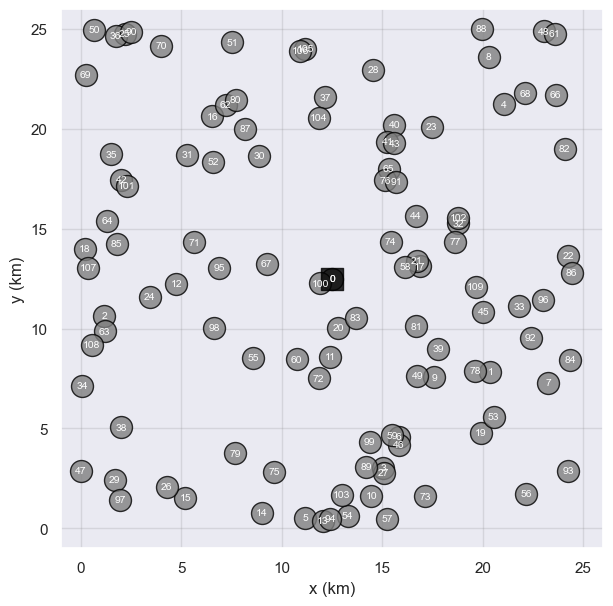

In [56]:
# Set data & control parameter
controls = dict(map_size=(25, 25), num_nodes=110, num_vehicles=1)
data = create_data_model(**controls)

plot_map(routes=[], **controls)
pd.json_normalize(data)

### VRP

Routes: [[0, 100, 67, 95, 98, 55, 60, 72, 11, 20, 83, 81, 39, 9, 49, 6, 46, 59, 99, 89, 3, 27, 10, 73, 57, 54, 103, 94, 13, 5, 14, 75, 79, 15, 26, 97, 29, 47, 38, 34, 108, 63, 2, 24, 12, 71, 52, 30, 87, 80, 62, 16, 31, 35, 42, 101, 64, 85, 18, 107, 69, 50, 90, 36, 25, 70, 51, 106, 105, 104, 37, 28, 40, 43, 41, 65, 76, 91, 44, 32, 102, 77, 23, 4, 68, 8, 88, 61, 48, 66, 82, 22, 86, 96, 33, 92, 84, 7, 93, 56, 19, 53, 1, 78, 45, 109, 17, 21, 58, 74, 0]], Length: 111
Vehicle 0: 197 km, 417.0 min, including 0 mins waiting time.
Total distance of all routes: : 197 km
Maximum travel time: 417.0 min


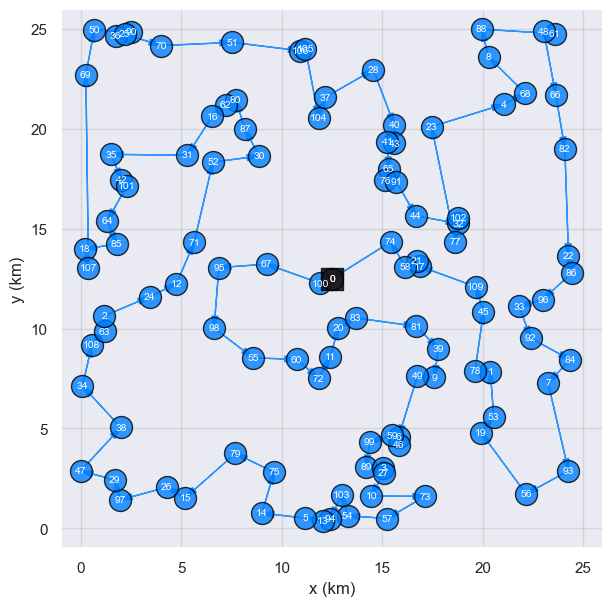

In [57]:
VRP_routes = solve_routing_problem(data)
total_dist, total_time, waiting_time = get_travelling_time(data, VRP_routes)
plot_map(routes=VRP_routes, **controls)

### VRP + Drone

Routes: [[0, 56, 26, 16, 21, 53, 5, 31, 20, 41, 88, 29, 101, 84, 34, 69, 66, 71, 104, 77, 44, 65, 43, 17, 82, 52, 108, 28, 42, 61, 72, 79, 81, 59, 87, 83, 106, 30, 54, 49, 90, 109, 11, 15, 40, 76, 78, 9, 2, 57, 98, 91, 86, 89, 19, 58, 60, 55, 92, 3, 99, 63, 6, 95, 32, 103, 96, 1, 22, 93, 73, 38, 10, 75, 47, 62, 64, 46, 33, 68, 105, 51, 35, 97, 50, 94, 67, 7, 23, 14, 39, 12, 13, 48, 80, 74, 27, 100, 8, 24, 70, 4, 45, 107, 36, 85, 25, 37, 102, 18, 0]], Length: 111
Waiting time: [[1.5, 0, 0.5, 1.0, 0, 0, 1.5, 0.75, 0, 0, 0, 0, 3.75, 0, 0]]
Vehicle 0: 198 km, 397.0 min, including 9.0 mins waiting time.
Total distance of all routes: : 198 km
Maximum travel time: 397.0 min


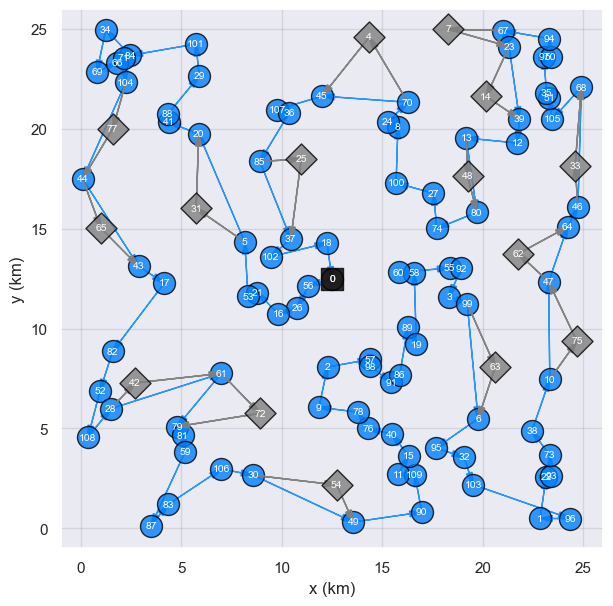

In [60]:
# 解 VRP -> 分開挑選 Drone 點 -> 連接路線
data = create_data_model(**controls)
VRPD_routes = solve_routing_problem(data)
drone_routes = select_drone_nodes(data, VRPD_routes)
# 調整車輛路線
for index, group in enumerate(drone_routes):
    for r in group:
        VRPD_routes[index].remove(r[1])

drone_waiting = get_waiting_time(data, VRPD_routes, drone_routes, 'drone')
print("Waiting time:", drone_waiting)
total_dist, total_time, waiting_time = get_travelling_time(data, VRPD_routes, drone_waiting)

plot_map(routes=VRPD_routes, drone_routes=drone_routes, robot_routes=[], **controls)

### VRP + Robot

Routes: [[0, 65, 57, 14, 19, 48, 98, 72, 75, 84, 43, 24, 27, 55, 93, 101, 87, 66, 15, 91, 96, 100, 5, 13, 12, 103, 37, 23, 108, 61, 20, 76, 51, 45, 22, 88, 10, 4, 36, 74, 59, 44, 99, 62, 33, 92, 58, 6, 18, 102, 17, 41, 31, 8, 42, 95, 54, 34, 85, 3, 7, 73, 67, 50, 79, 32, 70, 47, 60, 30, 21, 109, 97, 53, 28, 2, 26, 56, 80, 105, 38, 40, 63, 9, 52, 25, 64, 69, 35, 71, 82, 1, 86, 68, 89, 107, 16, 49, 94, 90, 77, 104, 106, 81, 11, 39, 83, 29, 46, 78, 0]], Length: 111
Robot Routes: [[[42, 95, 54, 34, 85, 3, 7, 73, 67, 50, 79, 32], [94, 90, 77, 104, 106, 81, 11, 39, 83, 29, 46, 78], [12, 103, 37, 23, 108, 61, 20, 76, 51, 45, 22, 88], [74, 59, 44, 99, 62, 33, 92, 58, 6, 18, 102, 17], [70, 47, 60, 30, 21, 109, 97, 53, 28, 2, 26, 56]]]
Route: [0, 65, 57, 14, 19, 48, 98, 72, 75, 84, 43, 24, 27, 55, 93, 101, 87, 66, 15, 91, 96, 100, 5, 13, 12, 88, 10, 4, 36, 74, 17, 41, 31, 8, 42, 32, 70, 56, 80, 105, 38, 40, 63, 9, 52, 25, 64, 69, 35, 71, 82, 1, 86, 68, 89, 107, 16, 49, 94, 78, 0], Robot Group: [

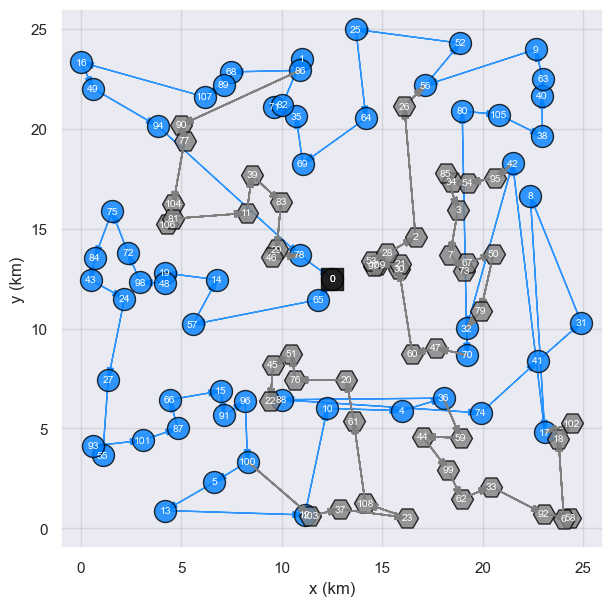

In [61]:
data = create_data_model(**controls)
VRPR_routes = solve_routing_problem(data)
robot_routes = select_robot_nodes(data, VRPR_routes)
# 調整車輛路線
for veh_i, group in enumerate(robot_routes):
    for index, route in enumerate(group):
        exclude_nodes = [item for sublist in robot_routes[veh_i] for item in sublist if 0 < sublist.index(item) < len(sublist) - 1]
        VRPR_routes[veh_i] = [i for i in VRPR_routes[veh_i] if i not in exclude_nodes]   
    VRPR_routes[veh_i], robot_routes[veh_i] = adjust_robot_route(data, VRPR_routes[veh_i], group)

robot_waiting = get_waiting_time(data, VRPR_routes, robot_routes, 'robot')
print("Waiting time:", robot_waiting)
total_dist, total_time, waiting_time = get_travelling_time(data, VRPR_routes, [], robot_waiting)

plot_map(routes=VRPR_routes, robot_routes=robot_routes, **controls)

# 舊版方法 (VRPTW)
# vrptw_routes = solve_vrptw(data, excludes)
# print('\nRoute for VRPTW:', vrptw_routes)
# if vrptw_routes:
#     robot_waiting = get_waiting_time(data, vrptw_routes, robot_routes, 'robot')
# plot_map(routes=vrptw_routes, drone_routes=[], robot_routes=robot_routes, **controls)

### VRP + Drone + Robot

Routes: [[0, 16, 54, 62, 51, 25, 53, 12, 59, 76, 50, 9, 30, 19, 2, 14, 104, 36, 33, 83, 5, 95, 29, 73, 101, 72, 108, 15, 106, 67, 109, 46, 24, 105, 27, 96, 10, 84, 21, 107, 37, 32, 60, 23, 98, 55, 44, 81, 56, 70, 49, 40, 39, 26, 17, 93, 65, 4, 86, 6, 42, 20, 88, 11, 77, 92, 58, 8, 103, 97, 52, 35, 47, 74, 69, 80, 79, 64, 99, 102, 71, 94, 38, 34, 31, 13, 1, 75, 43, 90, 100, 45, 78, 28, 85, 87, 41, 61, 48, 63, 7, 91, 66, 3, 22, 82, 18, 57, 68, 89, 0]], Length: 111
Robot Routes: [[[29, 73, 101, 72, 108, 15, 106, 67, 109, 46, 24, 105], [32, 60, 23, 98, 55, 44, 81, 56, 70, 49, 40, 39], [63, 7, 91, 66, 3, 22, 82, 18, 57, 68, 89, 0], [4, 86, 6, 42, 20, 88, 11, 77, 92, 58, 8, 103]]]
Route: [0, 16, 54, 62, 51, 25, 53, 12, 59, 76, 50, 9, 30, 19, 2, 14, 104, 36, 33, 83, 5, 95, 29, 105, 27, 96, 10, 84, 21, 107, 37, 32, 39, 26, 17, 93, 65, 4, 103, 97, 52, 35, 47, 74, 69, 80, 79, 64, 99, 102, 71, 94, 38, 34, 31, 13, 1, 75, 43, 90, 100, 45, 78, 28, 85, 87, 41, 61, 48, 63, 0], Robot Group: [[29, 73, 1

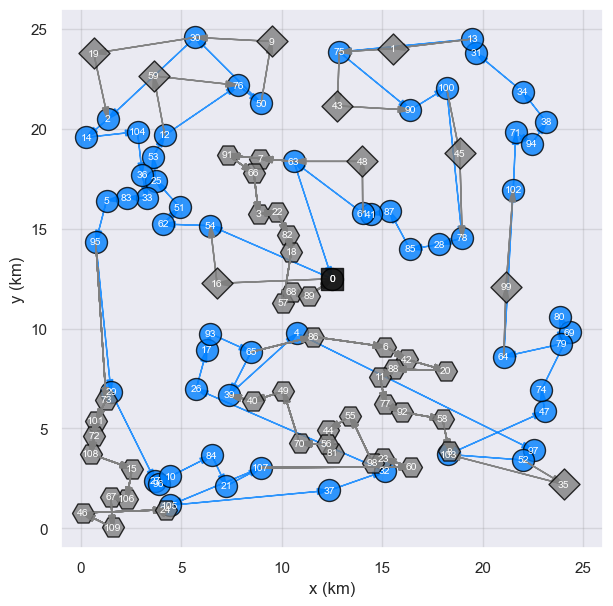

In [62]:
data = create_data_model(**controls)
VRPRD_routes = solve_routing_problem(data)

robot_routes = select_robot_nodes(data, VRPRD_routes)

for veh_i, group in enumerate(robot_routes):
    for index, route in enumerate(group):
        exclude_nodes = [item for sublist in robot_routes[veh_i] for item in sublist if 0 < sublist.index(item) < len(sublist) - 1]
        VRPRD_routes[veh_i] = [i for i in VRPRD_routes[veh_i] if i not in exclude_nodes]   
    VRPRD_routes[veh_i], robot_routes[veh_i] = adjust_robot_route(data, VRPRD_routes[veh_i], group)
    print(VRPRD_routes[veh_i], robot_routes[veh_i])

drone_routes = select_drone_nodes(data, VRPRD_routes, excludes=robot_routes)

for index, group in enumerate(drone_routes):
    for r in group:
        VRPRD_routes[index].remove(r[1])

drone_waiting = get_waiting_time(data, VRPRD_routes, drone_routes, 'drone')
robot_waiting = get_waiting_time(data, VRPRD_routes, robot_routes, 'robot')
print("Waiting time(d):", drone_waiting)
print("Waiting time(r):", robot_waiting)
total_dist, total_time, waiting_time = get_travelling_time(data, VRPRD_routes, drone_waiting, robot_waiting)

plot_map(routes=VRPRD_routes, drone_routes=drone_routes, robot_routes=robot_routes, **controls)

## Main: 設定參數與記錄實驗結果

In [29]:
def create_result_model():
    
    result = {}   
    # Parameters
    result["id"] = []
    result["map_size"] = []
    result["num_nodes"] = []
    result["num_locations"] = []
    result["num_vehicles"] = []
    result["vehicle_capacities"] = []
    # Result of VRP
    result["type"] = []
    result["truck_routes"] = []
    result["drone_routes"] = []
    result["robot_routes"] = []
    result["distances"] = []
    result["time"] = []
    result["waiting"] = []
    result["dispatch"] = []
    result["total_distance"] = []
    result["travel_time"] = []
    result["time_complexity"] = []
    result["space_complexity"] = []
    return result

def solve_by_VRP(data):
    start_time = time.time()
    tracemalloc.start()
    '''algorithm starts'''
    routes = solve_routing_problem(data)
    total_dist, total_time, waiting_time = get_travelling_time(data, routes)
    '''algorithm ends'''
    end_time = time.time()
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    time_complexity = round(end_time - start_time, 4)
    space_complexity = round(current / 1024, 4)
    VRP_result = dict(type='VRP', truck_routes=routes,  drone_routes=np.nan, robot_routes=np.nan, distances=total_dist, time=total_time, waiting=waiting_time, dispatch=0, total_distance=np.sum(total_dist), travel_time=max(total_time), time_complexity=time_complexity, space_complexity=space_complexity)
    return VRP_result

def solve_by_VRPD(data):
    start_time = time.time()
    tracemalloc.start()
    '''algorithm starts'''
    routes = solve_routing_problem(data)
    drone_routes = select_drone_nodes(data, routes)
    for index, group in enumerate(drone_routes):
        for r in group:
            routes[index].remove(r[1])
    drone_waiting = get_waiting_time(data, routes, drone_routes, 'drone')
    robot_waiting = [[] for i in range(len(drone_waiting))]
    total_dist, total_time, waiting_time = get_travelling_time(data, routes, drone_waiting, robot_waiting)
    # 考量派遣時間
    travel_time = total_time.copy()
    drone_dispatch = get_dispatch_time(drone_routes)
    for i, j in enumerate(drone_dispatch):
        travel_time[i] += waiting_time[i]
        travel_time[i] += j       
    '''algorithm ends'''
    end_time = time.time()
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    time_complexity = round(end_time - start_time, 4)
    space_complexity = round(current / 1024, 4)
    VRPD_result = dict(type='VRPD', truck_routes=routes, drone_routes=drone_routes, robot_routes=np.nan, distances=total_dist, time=total_time, waiting=waiting_time, dispatch=drone_dispatch, total_distance=np.sum(total_dist), travel_time=max(total_time), time_complexity=time_complexity, space_complexity=space_complexity)
    return VRPD_result

def solve_by_VRPR(data):
    start_time = time.time()
    tracemalloc.start()
    '''algorithm starts'''
    routes = solve_routing_problem(data)
    robot_routes = select_robot_nodes(data, routes)
    for veh_i, group in enumerate(robot_routes):
        for index, route in enumerate(group):
            exclude_nodes = [item for sublist in robot_routes[veh_i] for item in sublist if 0 < sublist.index(item) < len(sublist) - 1]
            routes[veh_i] = [i for i in routes[veh_i] if i not in exclude_nodes]   
        routes[veh_i], robot_routes[veh_i] = adjust_robot_route(data, routes[veh_i], group)
    robot_waiting = get_waiting_time(data, routes, robot_routes, 'robot')
    drone_waiting = [[] for i in range(len(robot_waiting))]
    total_dist, total_time, waiting_time = get_travelling_time(data, routes, drone_waiting, robot_waiting)  
    # 考量派遣時間
    robot_dispatch = get_dispatch_time(robot_routes)
    for i, j in enumerate(robot_dispatch):
        total_time[i] += j        
    '''algorithm ends'''
    end_time = time.time()
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    time_complexity = round(end_time - start_time, 4)
    space_complexity = round(current / 1024, 4)
    VRPR_result = dict(type='VRPR', truck_routes=routes,  drone_routes=np.nan, robot_routes=robot_routes, distances=total_dist, time=total_time, waiting=waiting_time, dispatch=robot_dispatch, total_distance=np.sum(total_dist), travel_time=max(total_time), time_complexity=time_complexity, space_complexity=space_complexity)
    return VRPR_result

def solve_by_VRPRD(data):
    start_time = time.time()
    tracemalloc.start()
    '''algorithm starts'''
    routes = solve_routing_problem(data)
    robot_routes = select_robot_nodes(data, routes)
    for veh_i, group in enumerate(robot_routes):
        for index, route in enumerate(group):
            exclude_nodes = [item for sublist in robot_routes[veh_i] for item in sublist if 0 < sublist.index(item) < len(sublist) - 1]
            routes[veh_i] = [i for i in routes[veh_i] if i not in exclude_nodes]   
        routes[veh_i], robot_routes[veh_i] = adjust_robot_route(data, routes[veh_i], group)
    drone_routes = select_drone_nodes(data, routes, excludes=robot_routes)
    for index, group in enumerate(drone_routes):
        for r in group:
            routes[index].remove(r[1])
    drone_waiting = get_waiting_time(data, routes, drone_routes, 'drone')
    robot_waiting = get_waiting_time(data, routes, robot_routes, 'robot')
    total_dist, total_time, waiting_time = get_travelling_time(data, routes, drone_waiting, robot_waiting)  
    # 考量派遣時間
    drone_dispatch = get_dispatch_time(drone_routes)
    robot_dispatch = get_dispatch_time(robot_routes)
    dispatch_time = [drone_dispatch[i]+robot_dispatch[i] for i in range(len(drone_dispatch))]
    for i, j in enumerate(zip(drone_dispatch, robot_dispatch)):
        total_time[i] += (j[0] + j[1])
    '''algorithm ends'''
    end_time = time.time()
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    time_complexity = round(end_time - start_time, 4)
    space_complexity = round(current / 1024, 4)
    VRPRD_result = dict(type='VRPRD', truck_routes=routes, drone_routes=drone_routes, robot_routes=robot_routes, distances=total_dist, time=total_time, waiting=waiting_time, dispatch=dispatch_time, total_distance=np.sum(total_dist), travel_time=max(total_time), time_complexity=time_complexity, space_complexity=space_complexity)
    return VRPRD_result

def save_exp_parameter(iter, data, **controls):
    result["id"].append(iter)
    result["map_size"].append((controls["map_size"][0], controls["map_size"][1]))
    result["num_nodes"].append(data["num_nodes"])
    result["num_locations"].append(data["num_locations"])
    result["num_vehicles"].append(controls["num_vehicles"])
    result["vehicle_capacities"].append(data["vehicle_capacities"])

# 地圖大小, 客戶點數量, 車輛數, 模擬次數
def simulate_experiment(**controls):

    for iter in range(1, controls["trials"]+1):
        print(f'Trial {iter}...')
        data = create_data_model(**controls)
        # 解 VRP & 記錄結果
        try:
            print('VRP')
            VRP_result = solve_by_VRP(data)
            save_exp_parameter(iter, data, **controls)
            for key, value in VRP_result.items():
                if key in result:
                    result[key].append(value)
        except:
            print('VRP Error!')
        # 解 VRP-D & 記錄結果
        try:
            print('VRPD')
            VRPD_result = solve_by_VRPD(data)
            save_exp_parameter(iter, data, **controls)
            for key, value in VRPD_result.items():
                if key in result:
                    result[key].append(value)
        except:
            print('VRP-D Error!')
        # 解 VRP-R & 記錄結果
        try:
            print('VRPR')
            VRPR_result = solve_by_VRPR(data)
            save_exp_parameter(iter, data, **controls)
            for key, value in VRPR_result.items():
                if key in result:
                    result[key].append(value)
        except: 
            print('VRP-R Error!')
        # 解 VRP-RD & 記錄結果
        try:
            print('VRPRD')
            VRPRD_result = solve_by_VRPRD(data)
            save_exp_parameter(iter, data, **controls)
            for key, value in VRPRD_result.items():
                if key in result:
                    result[key].append(value)
        except:
            print('VRP-RD Error!')

    print('\nDone!')

## 執行實驗

In [52]:
# 記錄結果
result = create_result_model()

map_size = (25, 25)
num_node = 110
num_trial = 30

# 設定實驗參數 & 實驗
ex_controls = dict(map_size=map_size, num_nodes=num_node, num_vehicles=1, trials=num_trial)
simulate_experiment(**ex_controls)

Trial 1...
VRP
Routes: [[0, 105, 17, 52, 81, 85, 106, 27, 6, 48, 94, 109, 103, 70, 2, 60, 72, 69, 31, 7, 55, 88, 62, 10, 30, 15, 97, 57, 82, 36, 108, 26, 12, 28, 51, 61, 11, 50, 18, 71, 84, 54, 87, 58, 101, 38, 66, 34, 63, 91, 22, 59, 41, 40, 78, 67, 83, 9, 102, 5, 23, 74, 107, 86, 46, 68, 25, 35, 13, 49, 29, 44, 21, 64, 92, 47, 95, 8, 1, 37, 53, 75, 65, 76, 24, 39, 96, 32, 20, 16, 14, 89, 3, 4, 93, 104, 42, 19, 33, 90, 73, 100, 98, 80, 79, 99, 77, 43, 45, 56, 0]], Length: 111
Vehicle 0: 198 km, 418.0 min, including 0 mins waiting time.
Total distance of all routes: : 198 km
Maximum travel time: 418.0 min
VRPD
Routes: [[0, 105, 17, 52, 81, 85, 106, 27, 6, 48, 94, 109, 103, 70, 2, 60, 72, 69, 31, 7, 55, 88, 62, 10, 30, 15, 97, 57, 82, 36, 108, 26, 12, 28, 51, 61, 11, 50, 18, 71, 84, 54, 87, 58, 101, 38, 66, 34, 63, 91, 22, 59, 41, 40, 78, 67, 83, 9, 102, 5, 23, 74, 107, 86, 46, 68, 25, 35, 13, 49, 29, 44, 21, 64, 92, 47, 95, 8, 1, 37, 53, 75, 65, 76, 24, 39, 96, 32, 20, 16, 14, 89, 3, 4

In [63]:
df_result = pd.DataFrame(result)
df_result

,id,map_size,num_nodes,num_locations,num_vehicles,vehicle_capacities,type,truck_routes,drone_routes,robot_routes,distances,time,waiting,dispatch,total_distance,travel_time,time_complexity,space_complexity
0,1,"(25, 25)",110,"[(12.5, 12.5), (13.89, 15.66), (10.94, 8.25), ...",1,[110],VRP,"[[0, 105, 17, 52, 81, 85, 106, 27, 6, 48, 94, ...",NaN,NaN,[198],[418.0],[0],0,198,418.00,5.1613,3.3799
1,1,"(25, 25)",110,"[(12.5, 12.5), (13.89, 15.66), (10.94, 8.25), ...",1,[110],VRPD,"[[0, 105, 17, 52, 81, 85, 106, 27, 6, 94, 109,...","[[[60, 72, 69], [44, 21, 64], [14, 89, 3], [79...",NaN,[199],[396.75],[5.75],[28],199,396.75,4.6853,6.1982
2,1,"(25, 25)",110,"[(12.5, 12.5), (13.89, 15.66), (10.94, 8.25), ...",1,[110],VRPR,"[[0, 103, 70, 2, 60, 72, 109, 69, 31, 7, 55, 8...",NaN,"[[[3, 104, 42, 19, 33, 90, 73, 100, 98, 80, 79...",[220],[351.0],[1.0],[10],220,351.00,4.9442,17.9668
3,1,"(25, 25)",110,"[(12.5, 12.5), (13.89, 15.66), (10.94, 8.25), ...",1,[110],VRPRD,"[[0, 103, 70, 2, 60, 109, 69, 31, 7, 55, 88, 6...","[[[60, 72, 109], [23, 21, 64], [14, 89, 3], [1...","[[[3, 104, 42, 19, 33, 90, 73, 100, 98, 80, 79...",[208],[367.0],[29.0],[26],208,367.00,4.7181,10.2686
4,2,"(25, 25)",110,"[(12.5, 12.5), (24.65, 12.04), (16.82, 19.03),...",1,[110],VRP,"[[0, 80, 3, 5, 34, 86, 9, 17, 52, 15, 108, 19,...",NaN,NaN,[211],[431.0],[0],0,211,431.00,4.1177,3.2725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,29,"(25, 25)",110,"[(12.5, 12.5), (9.41, 12.22), (21.53, 22.4), (...",1,[110],VRPRD,"[[0, 20, 16, 26, 77, 33, 42, 52, 79, 28, 38, 2...","[[[67, 51, 36], [58, 82, 100], [11, 94, 95], [...","[[[0, 46, 3, 106, 76, 10, 102, 21, 35, 30, 48,...",[221],[378.75],[9.75],[32],221,378.75,4.0919,11.5586
116,30,"(25, 25)",110,"[(12.5, 12.5), (13.81, 0.99), (0.4, 20.71), (5...",1,[110],VRP,"[[0, 5, 71, 83, 68, 14, 24, 87, 95, 20, 17, 10...",NaN,NaN,[220],[440.0],[0],0,220,440.00,5.2045,3.3271
117,30,"(25, 25)",110,"[(12.5, 12.5), (13.81, 0.99), (0.4, 20.71), (5...",1,[110],VRPD,"[[0, 5, 71, 83, 68, 14, 24, 95, 17, 108, 40, 3...","[[[96, 16, 52], [19, 101, 22], [30, 13, 28], [...",NaN,[201],[391.75],[4.75],[34],201,391.75,5.2081,4.5781
118,30,"(25, 25)",110,"[(12.5, 12.5), (13.81, 0.99), (0.4, 20.71), (5...",1,[110],VRPR,"[[0, 108, 8, 106, 46, 6, 90, 9, 26, 18, 69, 23...",NaN,"[[[3, 88, 41, 85, 93, 36, 58, 98, 91, 51, 103,...",[233],[394.0],[31.0],[10],233,394.00,5.0829,11.1465


<AxesSubplot: xlabel='id', ylabel='travel_time'>

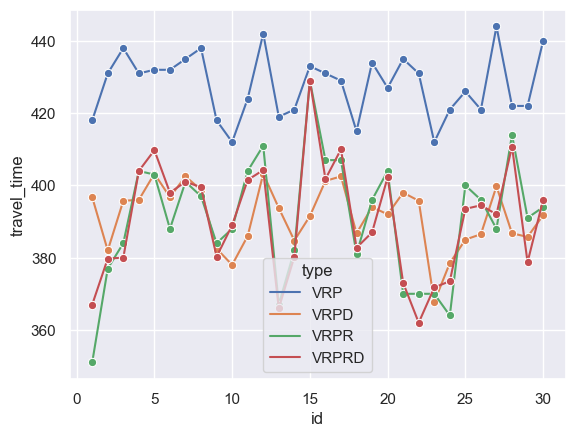

In [64]:
sns.lineplot(data=df_result, x='id', y='travel_time', hue='type', marker='o')

In [50]:
from datetime import datetime
from datetime import date

In [55]:
today = date.today()
now = datetime.now()
today_str = today.strftime("%Y-%m-%d")
current_time = now.strftime("%H-%M-%S-%f")
current_time
df_result.to_csv(f'./vrp_result_{map_size[0]}x{map_size[1]}_{num_trial}_{today_str}_{current_time}.csv')